## Deep Hedging
### Notebook for computing utility values without any hedging. Helps comparing different lambda values. 


In [1]:
import os
p = os.getcwd()
print(p)
dhn = "/deephedging"
i = p.find(dhn)
if i!=-1:
    p = p[:i]
    import sys
    sys.path.append(p)
    print("SageMaker: added python path %s" % p)

/home/ec2-user/SageMaker/deephedging
SageMaker: added python path /home/ec2-user/SageMaker


Deep Hedging AI says hello ... Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs


## Computing Utility Values for a Payoff

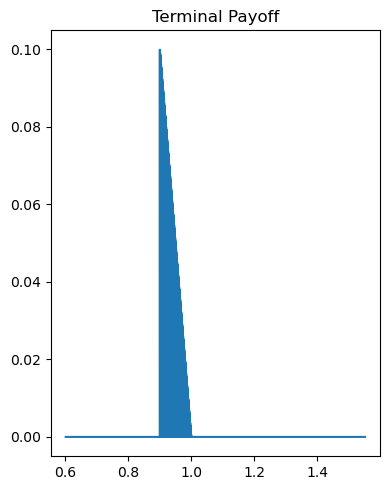

Utility computed using minimize_scalar: 0.00656505
Utility computed using TensorFlow: 0.00652202 (with full batch)


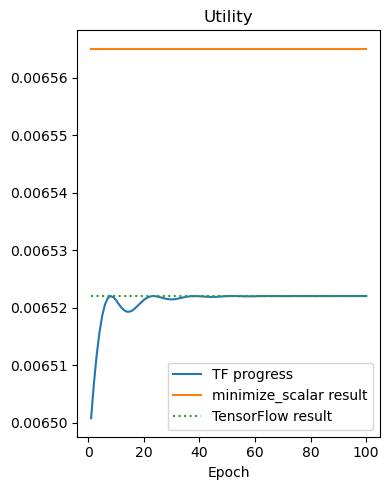

In [11]:
print("Deep Hedging AI says hello ... ", end='')
from cdxbasics.config import Config

import importlib as imp
import deephedging.base as _
imp.reload(_)
import deephedging.layers as _
imp.reload(_)
import deephedging.agents as _
imp.reload(_)
import deephedging.objectives as _
imp.reload(_)
import deephedging.world as _
imp.reload(_)
import deephedging.gym as _
imp.reload(_)
import deephedging.trainer as _
imp.reload(_)

from deephedging.trainer import train, train_utillity
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
from deephedging.objectives import MonetaryUtility
import numpy as np

from cdxbasics.dynaplot import figure
from IPython.display import display, Markdown

# create world
# ------------

def barrier_option( spots ):
    """ KO 
    
        Parameters
        ----------
            spots : spots of the equity[None,nSteps]
            
        Returns
        -------
            Payoff [None]
    """
    pcent      = 0.1
    put_strike = 1.0
    lower_KO   = 1.-pcent
    upper_KO   = 1.+pcent
    terminal   = np.maximum( put_strike - spots[:,-1], 0. )  # put
    lower      = np.where( np.min( spots, axis=1 ) >= lower_KO, 1., 0. )
    upper      = np.where( np.max( spots, axis=1 ) <= upper_KO, 1., 0. )
    return terminal*lower*upper

wconfig = Config()
wconfig.samples = 10000
wconfig.steps = 20
wconfig.black_scholes = True
wconfig.payoff = barrier_option
world  = SimpleWorld_Spot_ATM( wconfig )
val_world  = world.clone(samples=world.nSamples//10)

display(Markdown("## Computing Utility Values for a Payoff"))

fig = figure()
ax  = fig.add_subplot()
ax.set_title("Terminal Payoff")
spotsT = world.details.spot_all[:,-1]
payoff = world.data.market.payoff
ixs    = np.argsort(spotsT)
spotsT = spotsT[ixs]
payoff = payoff[ixs]
ax.plot( spotsT,payoff )
fig.render()
fig.close()

uconfig = Config()
uconfig.utility = "exp2"
uconfig.lmbda = 1.

utility = MonetaryUtility( uconfig )

# compute utility with minimize_scalar
# This will only work for utilities which are not state-dependent

u1 = utility.compute_stateless_utility( world.tf_data['market']['payoff'], sample_weights=world.sample_weights )
print("Utility computed using minimize_scalar: %g" % u1) 

# compute utility with tensorflow
# this should work for all utillities, but is much slower

tconfig = Config()
tconfig.train.optimizer.name = "adam"
tconfig.train.batch_size = world.nSamples # full sample size
tconfig.train.epochs = 100
tconfig.train.tf_verbose = 0

u, u0, info = train_utillity( utility, world, config=tconfig )
print("Utility computed using TensorFlow: %g (with full batch)" % u) 

fig = figure()
ax = fig.add_subplot()
ax.set_title("Utility")
h  = - np.array( info.history['loss'] )
l  = len(h)
x  = np.linspace(1,l,l,endpoint=True)
ax.set_xlabel("Epoch")
ax.plot( x, h, label="TF progress")
ax.plot( x, x*0. + u1, label="minimize_scalar result")
ax.plot( x, x*0. + u , ":", label="TensorFlow result")
ax.legend()
fig.show()
fig.close()

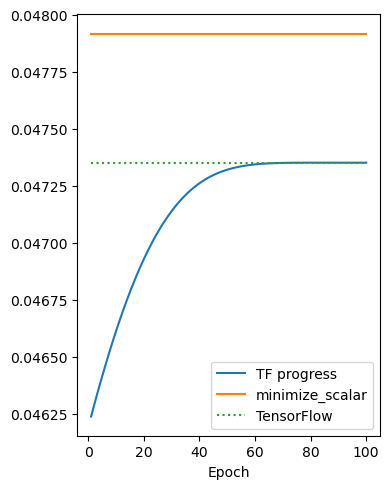

## Computing Different Utility Values

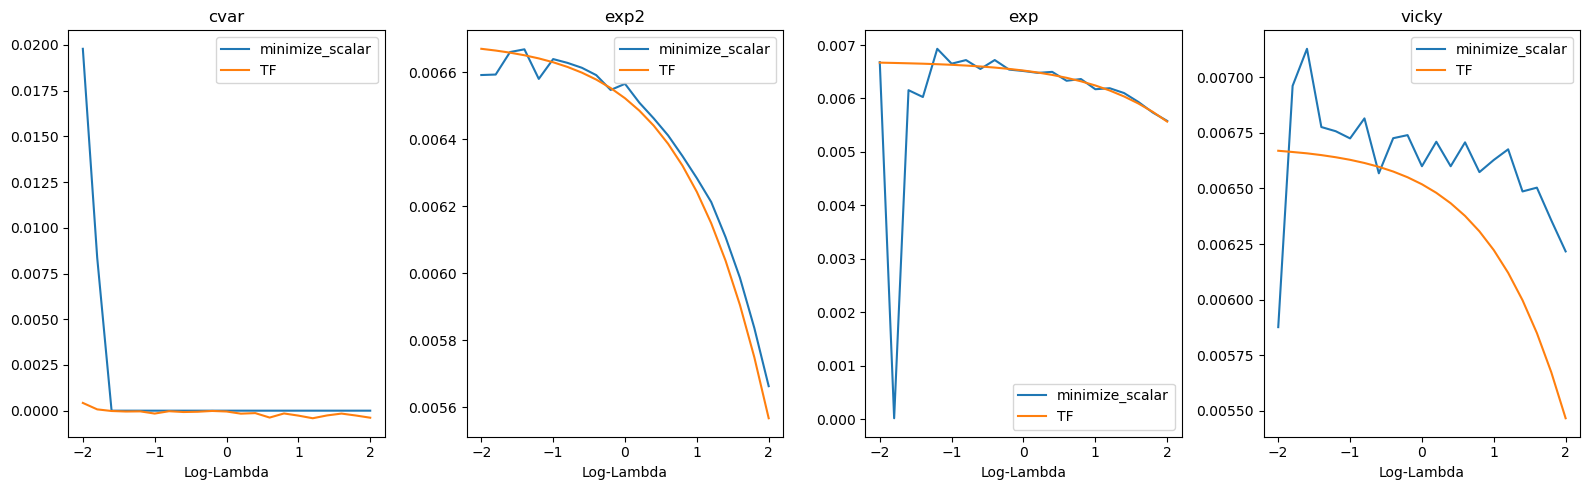

100%|██████████| 4/4 [04:02<00:00, 60.65s/it]


In [20]:
from tqdm import tqdm

display(Markdown("## Computing Different Utility Values"))

# create monetary utility
# ------------------------

utilities = ['cvar', 'exp2', 'exp', 'vicky' ]
lambdas  = np.exp(np.linspace( -2.,2., 21, endpoint=True) )

fig = figure()

for util in tqdm(utilities):
    r1 = []
    r2 = []

    ax  = fig.add_subplot()
    ax.set_title(util)
    ax.set_xlabel("Log-Lambda")

    for lmbda in tqdm(lambdas):
        uconfig = Config()
        uconfig.utility = util
        uconfig.lmbda = lmbda

        utility = MonetaryUtility( uconfig )

        u1 = utility.compute_stateless_utility( world.tf_data['market']['payoff'], tol=1E-12 )
        r1.append( u1 )
        
        # compute utility with tensorflow
        # this should work for all utillities, but is much slower

        tconfig = Config()
        tconfig.train.optimizer.name = "adam"
        tconfig.train.batch_size = world.nSamples # full sample size
        tconfig.train.epochs = 100
        tconfig.train.tf_verbose = 0

        u2, _, _ = train_utillity( utility, world, config=tconfig )
        r2.append(u2)
        
    ax.plot( np.log(lambdas), r1, label="minimize_scalar" )
    ax.plot( np.log(lambdas), r2, label="TF" )
    ax.legend()

fig.render()
fig.close()